In [54]:
# !pip install xgboost 
# !pip install lightgbm 
# !pip install catboost 
!jupyter nbconvert --to html project_BANTAS.ipynb

[NbConvertApp] Converting notebook project_BANTAS.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 1907761 bytes to project_BANTAS.html


# Supervised Learning
Finally, our aim is to develop a classifier that can predict hypoxia in each cell type. We will start with developing pipeline of several different classifiers on Smartseq filtered and normalized datasets first, compare their performances and select the model with best performance in each cell type that will be used to generate final predictions. 
Throughout this section we will focus on dimensionality reduction using PCA and testing following regression/classification models:
- Support Vector Machines
- Logistic Regression
- Decision Trees
- Random Forests
- K-Nearest Neighbours

We are using sklearn's Pipeline and GridSearch for streamlining the way we handle the SL algorithms and for being able to test multiple 


In [ ]:
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline     
# sns.set(color_codes=True)

In [44]:
# unfiltered data
mcf_smart_unfiltered = "./dataset/MCF7_SmartS_Unfiltered_Data.txt"
hcc_smart_unfiltered = "./dataset/HCC1806_SmartS_Unfiltered_Data.txt"

#filtered data
mcf_smart_filtered = "./dataset/MCF7_SmartS_Filtered_Data.txt"
hcc_smart_filtered = "./dataset/HCC1806_SmartS_Filtered_Data.txt"

# meta data
mcf_meta = "./dataset/MCF7_SmartS_MetaData.tsv"
hcc_meta = "./dataset/HCC1806_SmartS_MetaData.tsv"

# filtered normalised data
mcf_smart = "./dataset/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt"
hcc_smart = "./dataset/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt"
mcf_drop = "./dataset/MCF7_Filtered_Normalised_3000_Data_train.txt"
hcc_drop = "./dataset/HCC1806_Filtered_Normalised_3000_Data_train.txt"

# test data
mcf_smart_test = "./dataset/MCF7_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt"
hcc_smart_test = "./dataset/HCC1806_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt"
mcf_drop_test = "./dataset/MCF7_Filtered_Normalised_3000_Data_test_anonim.txt"
hcc_drop_test = "./dataset/HCC1806_Filtered_Normalised_3000_Data_test_anonim.txt"

### SmartSeq 
Firstly, we will start with a brief exploration of Smartseq reduced datasets that are filtered and normalized. Exploratory data analysis showed us that our unfiltered MCF7 smartseq dataset is around 60% sparse. This is why we will start from reduced datasets in order to prevent overfitting and use them for building classifiers.

In [4]:
# We create a function that reads the data and creates labels

def open_file(file):
    df = pd.read_csv(file, delimiter='\ ', engine = 'python', index_col=0)
    df = df.T
    index = np.array([])
    for name in df.index:
        if 'Hypo' in name:
            index = np.append(index, 'Hypoxic')
        else:
            index = np.append(index, 'Normoxic')
    return df, index

df1, index1 = open_file(mcf_smart)
df2, index2 = open_file(hcc_smart)
df3, index3 = open_file(mcf_drop)
df4, index4 = open_file(hcc_drop)

#### 1. MCF7 SmartSeq 

In MCF7 SS, we work with 250 data points, each described by 3000 genes. To use genes as our features for the prediction, we must do some kind of dimensionality reduction and feature extraction. Let's use PCA.

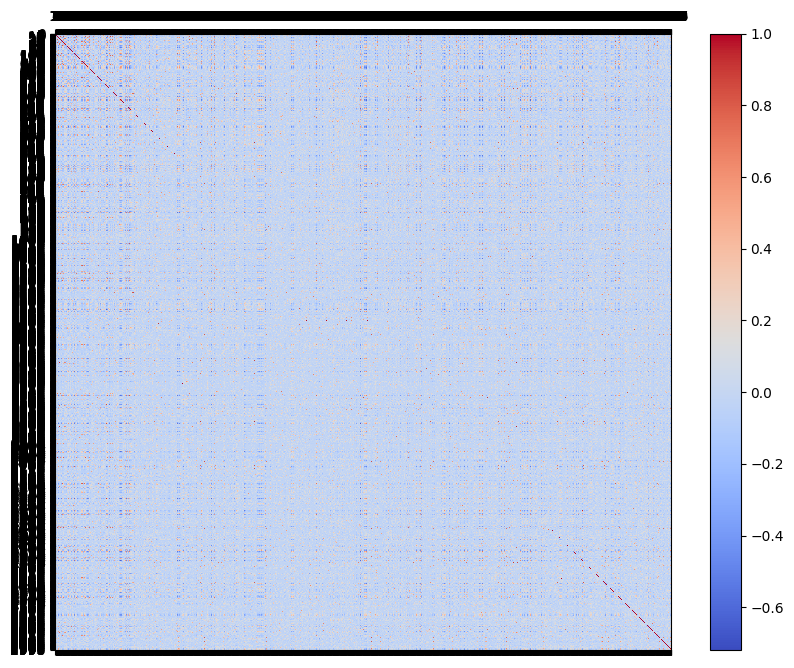

"CYP1B1"        0
"CYP1B1-AS1"    0
"CYP1A1"        0
"NDRG1"         0
"DDIT4"         0
               ..
"GRIK5"         0
"SLC25A27"      0
"DENND5A"       0
"CDK5R1"        0
"FAM13A-AS1"    0
Length: 3000, dtype: int64
0
Hypoxic 124 and Normoxic 126


In [5]:
corr_matrix = df1.corr()

# Create a heatmap using matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr_matrix, cmap='coolwarm')

# Add color bar
fig.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))

# Set axis tick labels
# ax.set_xticklabels(corr_matrix.columns, rotation=90)
# ax.set_yticklabels(corr_matrix.columns)

# Show the plot
plt.show()

# Check for missing values
print(df1.isnull().sum())

# Outliers?

# Duplicates
print(df1.duplicated().sum())

# Classes
count = sum(1 for i in index1 if i == "Hypoxic")
print("Hypoxic",count,"and Normoxic", df1.shape[0]-count)

The correlation matrix is 3000x3000, so there are enough features to remove. Also, we've done some preliminary data validation: no duplicated, no missing features, balance of classes.
#### Start PCA
Firstly we scale/normalize data frame using sklearn in-built scaler for its PCA algorithm. This first step is crucial, because allows the features to be comparable.Without this, dimensions with higher variation, but lower relevance, would be chosen first.

In [6]:
from sklearn.preprocessing import StandardScaler

#Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(df1)

# Transform the data using the scaler
df1_scaled = scaler.transform(df1)

# Convert the scaled data back to a DataFrame
df1_scaled_final = pd.DataFrame(df1_scaled, columns=df1.columns)

print("N.o. dimensions originally:", df1_scaled_final.shape[1])

N.o. dimensions originally: 3000


In [7]:
from sklearn.decomposition import PCA
# We create a PCA object with n_components that explain 99% of variance
pca = PCA(n_components=0.99)

# We fit the PCA model to our scaled dataset in order to transform it to the lower-dimensional space
df1_reduced = pca.fit_transform(df1_scaled_final)

print("N.o. dimensions kept by PCA:", df1_reduced.shape[1])

N.o. dimensions kept by PCA: 237


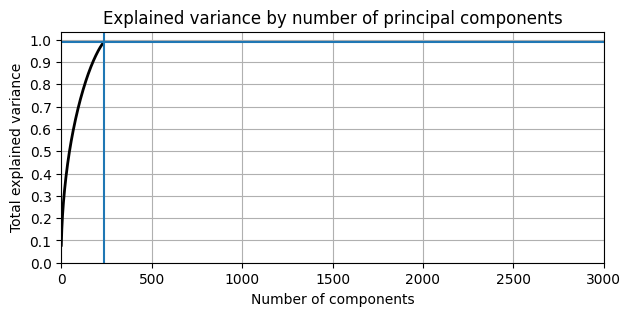

In [8]:
# Plotting
plt.figure(figsize=(7,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, df1_scaled_final.shape[1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(237)
plt.axhline(0.99) 
plt.grid(True)
plt.title('Explained variance by number of principal components')
plt.show()

From the plot, we can see that around 180-230 dimensions are need in order to explain 90% to 99% of the variance in the data. 
Now import the required classes from sklearn:

In [9]:
# Pipeline, Gridsearch, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

from scipy import stats

mode = stats.mode(df1, keepdims=True)
import warnings
warnings.filterwarnings('ignore')

In [10]:

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df1_scaled_final, index1, test_size=0.2, random_state=42)

pipe_lr = Pipeline([('PCA', pca),
                    ('LR', LogisticRegression(random_state=42))])
pipe_dt = Pipeline([(('PCA', pca)),
                    ('DT',DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([(('PCA', pca)),
                    ('RF',RandomForestClassifier(random_state=42))])
pipe_knn = Pipeline([(('PCA', pca)),
                    ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([(('PCA', pca)),
                     ('SVM', svm.SVC(random_state=42))])

lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                   'LR__C': [0.1, 1.0, 10],
                   'LR__solver': ['liblinear']}]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': [1, 2, 4, 6, 8],
                   'DT__max_depth': [None, 10, 20, 30, 40],
                   'DT__min_samples_split': [2, 5, 10]}]
rf_param_grid = [{'RF__min_samples_leaf': [1, 2, 4],
                   'RF__max_depth': [None, 10, 20, 30, 40],
                   'RF__min_samples_split': [2, 5, 10]}]
knn_param_grid = [{'KNN__n_neighbors':[3,5,7,9],
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]
svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': [0.01, 0.1, 1, 10]}]

lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid,
        scoring='accuracy',
        cv=5)
dt_grid_search = GridSearchCV(estimator=pipe_dt,
        param_grid=dt_param_grid,
        scoring='accuracy',
        cv=5)
rf_grid_search = GridSearchCV(estimator=pipe_rf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=5)
knn_grid_search = GridSearchCV(estimator=pipe_knn,
        param_grid=knn_param_grid,
        scoring='accuracy',
        cv=5)
svm_grid_search = GridSearchCV(estimator=pipe_svm,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=5)     

grids = [lr_grid_search, dt_grid_search, rf_grid_search, knn_grid_search, svm_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines'}
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],
    model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))   

Logistic Regression Test Accuracy: 1.0
Logistic Regression Best Params: {'LR__C': 0.1, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'}
Decision Trees Test Accuracy: 1.0
Decision Trees Best Params: {'DT__criterion': 'gini', 'DT__max_depth': None, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 2}
Random Forest Test Accuracy: 1.0
Random Forest Best Params: {'RF__max_depth': None, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}
K-Nearest Neighbors Test Accuracy: 0.94
K-Nearest Neighbors Best Params: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 9, 'KNN__weights': 'uniform'}
Support Vector Machines Test Accuracy: 1.0
Support Vector Machines Best Params: {'SVM__C': 0.01, 'SVM__kernel': 'linear'}


We did:
1. Data scaling before applying PCA.
2. Pipeline Construction where each model is included in a pipeline with PCA to streamline the process.
3. GridSearchCV is used to perform hyperparameter tuning for each model.
4. Fitting and Evaluation

Since all 5 methods achived an accuracy of 100% after performing PCA, which in most cases means that the models are overfitting, but the data is linearly separable from last section. We do the same for the non-scaled datasets.

In [11]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df1, index1, test_size=0.2, random_state=42)

pipe_lr = Pipeline([('PCA', pca),
                    ('LR', LogisticRegression(random_state=42))])
pipe_dt = Pipeline([(('PCA', pca)),
                    ('DT',DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([(('PCA', pca)),
                    ('RF',RandomForestClassifier(random_state=42))])
pipe_knn = Pipeline([(('PCA', pca)),
                    ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([(('PCA', pca)),
                     ('SVM', svm.SVC(random_state=42))])

lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                   'LR__C': [0.1, 1.0, 10],
                   'LR__solver': ['liblinear']}]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': [1, 2, 4, 6, 8],
                   'DT__max_depth': [None, 10, 20, 30, 40],
                   'DT__min_samples_split': [2, 5, 10]}]
rf_param_grid = [{'RF__min_samples_leaf': [1, 2, 4],
                   'RF__max_depth': [None, 10, 20, 30, 40],
                   'RF__min_samples_split': [2, 5, 10]}]
knn_param_grid = [{'KNN__n_neighbors':[3,5,7,9],
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]
svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': [0.01, 0.1, 1, 10]}]

lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid,
        scoring='accuracy',
        cv=5)
dt_grid_search = GridSearchCV(estimator=pipe_dt,
        param_grid=dt_param_grid,
        scoring='accuracy',
        cv=5)
rf_grid_search = GridSearchCV(estimator=pipe_rf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=5)
knn_grid_search = GridSearchCV(estimator=pipe_knn,
        param_grid=knn_param_grid,
        scoring='accuracy',
        cv=5)
svm_grid_search = GridSearchCV(estimator=pipe_svm,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=5)     

grids = [lr_grid_search, dt_grid_search, rf_grid_search, knn_grid_search, svm_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines'}
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],
    model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))   

Logistic Regression Test Accuracy: 0.98
Logistic Regression Best Params: {'LR__C': 0.1, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
Decision Trees Test Accuracy: 0.96
Decision Trees Best Params: {'DT__criterion': 'gini', 'DT__max_depth': None, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 2}
Random Forest Test Accuracy: 0.98
Random Forest Best Params: {'RF__max_depth': None, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}
K-Nearest Neighbors Test Accuracy: 0.96
K-Nearest Neighbors Best Params: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 5, 'KNN__weights': 'uniform'}
Support Vector Machines Test Accuracy: 0.96
Support Vector Machines Best Params: {'SVM__C': 0.01, 'SVM__kernel': 'linear'}


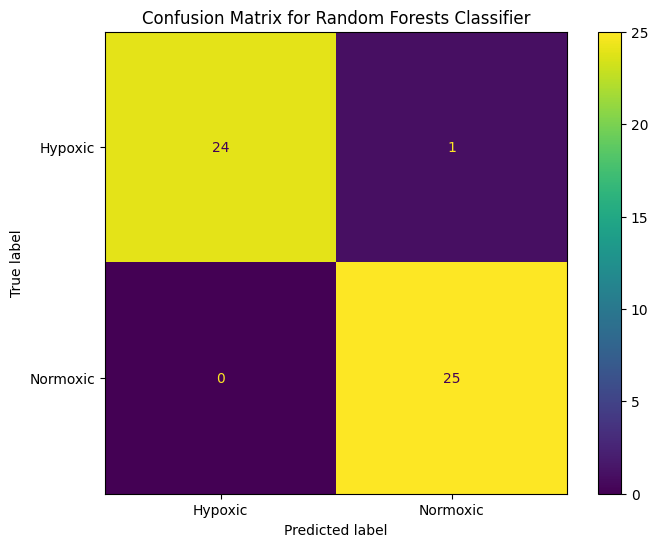

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plot confusion matrix for Decision Trees
dt_model = grids[2]  
y_pred_dt = dt_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(ax=ax)
plt.title('Confusion Matrix for Random Forests Classifier')
plt.show()

We are ready to make predictions on newly added test data.

In [13]:
# Load your new test data
new_test_df, new_test_index = open_file(mcf_smart_test)

# Generate predictions
predictions1 = rf_grid_search.predict(new_test_df)

# Create a dataframe from predictions
df_predictions1 = pd.DataFrame(predictions1, columns=['predictions'])

# Save predictions to a tab-delimited file
df_predictions1.to_csv('./Outputs/predictions_MCF7_SSeq_RandomForests.txt', sep='\t', index=False)

#### 2. HCC SmartSeq

In [14]:
print(df2.shape)
# Check for missing values
print(df1.isnull().sum())

# Outliers?

# Duplicates
print(df1.duplicated().sum())

# Classes
count = sum(1 for i in index1 if i == "Hypoxic")
print(count)

(182, 3000)
"CYP1B1"        0
"CYP1B1-AS1"    0
"CYP1A1"        0
"NDRG1"         0
"DDIT4"         0
               ..
"GRIK5"         0
"SLC25A27"      0
"DENND5A"       0
"CDK5R1"        0
"FAM13A-AS1"    0
Length: 3000, dtype: int64
0
124


In HCC SSeq, we work with fewer data points, but same number of 3000 genes. Let's do the same data scaling as before and do dimensionality reduction with PCA.

In [15]:
from sklearn.preprocessing import StandardScaler

#Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(df2)

# Transform the data using the scaler
df2_scaled = scaler.transform(df2)

# Convert the scaled data back to a DataFrame
df2_scaled_final = pd.DataFrame(df2_scaled, columns=df2.columns)

print("N.o. dimensions originally:", df2_scaled_final.shape[1])

N.o. dimensions originally: 3000


In [16]:
from sklearn.decomposition import PCA
# We create a PCA object with n_components that explain 99% of variance
pca = PCA(n_components=0.99)

# We fit the PCA model to our scaled dataset in order to transform it to the lower-dimensional space
df2_reduced = pca.fit_transform(df2_scaled_final)

print("N.o. dimensions kept by PCA:", df2_reduced.shape[1])

N.o. dimensions kept by PCA: 175


In [17]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df2_scaled_final, index2, test_size=0.2, random_state=42)

pipe_lr = Pipeline([('PCA', pca),
                    ('LR', LogisticRegression(random_state=42))])
pipe_dt = Pipeline([(('PCA', pca)),
                    ('DT',DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([(('PCA', pca)),
                    ('RF',RandomForestClassifier(random_state=42))])
pipe_knn = Pipeline([(('PCA', pca)),
                    ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([(('PCA', pca)),
                     ('SVM', svm.SVC(random_state=42))])

lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                   'LR__C': [0.1, 1.0, 10],
                   'LR__solver': ['liblinear']}]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': [1, 2, 4, 6, 8],
                   'DT__max_depth': [None, 10, 20, 30, 40],
                   'DT__min_samples_split': [2, 5, 10]}]
rf_param_grid = [{'RF__min_samples_leaf': [1, 2, 4],
                   'RF__max_depth': [None, 10, 20, 30, 40],
                   'RF__min_samples_split': [2, 5, 10]}]
knn_param_grid = [{'KNN__n_neighbors':[3,5,7,9],
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]
svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': [0.01, 0.1, 1, 10]}]

lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid,
        scoring='accuracy',
        cv=5)
dt_grid_search = GridSearchCV(estimator=pipe_dt,
        param_grid=dt_param_grid,
        scoring='accuracy',
        cv=5)
rf_grid_search = GridSearchCV(estimator=pipe_rf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=5)
knn_grid_search = GridSearchCV(estimator=pipe_knn,
        param_grid=knn_param_grid,
        scoring='accuracy',
        cv=5)
svm_grid_search = GridSearchCV(estimator=pipe_svm,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=5)     

grids = [lr_grid_search, dt_grid_search, rf_grid_search, knn_grid_search, svm_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines'}
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],
    model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))   

Logistic Regression Test Accuracy: 0.972972972972973
Logistic Regression Best Params: {'LR__C': 1.0, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
Decision Trees Test Accuracy: 0.8648648648648649
Decision Trees Best Params: {'DT__criterion': 'gini', 'DT__max_depth': None, 'DT__min_samples_leaf': 6, 'DT__min_samples_split': 2}
Random Forest Test Accuracy: 0.972972972972973
Random Forest Best Params: {'RF__max_depth': None, 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 5}
K-Nearest Neighbors Test Accuracy: 0.43243243243243246
K-Nearest Neighbors Best Params: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 7, 'KNN__weights': 'uniform'}
Support Vector Machines Test Accuracy: 1.0
Support Vector Machines Best Params: {'SVM__C': 0.01, 'SVM__kernel': 'linear'}


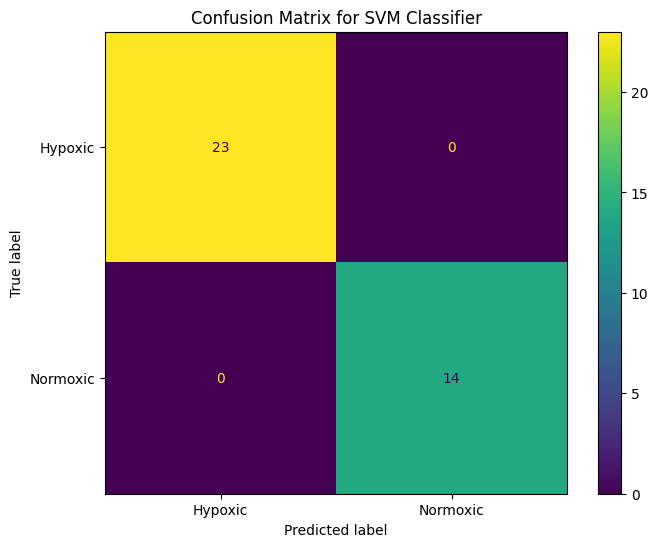

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
dt_model = grids[4]  
y_pred_dt = dt_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(ax=ax)
plt.title('Confusion Matrix for SVM Classifier')
plt.show()

On the scaled SmartSeq dataset for HCC cell lines, only Support Vector Machines (SVM) achieved 100% accuracy. Notably, we did not modify the parameter values in the parameter grid.

Surprisingly, when comparing performance between the two cell types, KNN, Decision Trees, and Random Forests showed much lower performance on the HCC cell line compared to MCF7. Logistic Regression and SVM maintained high accuracy in both cell types. Additionally, we applied the same pipeline to the unscaled SmartSeq dataset for HCC. In this case, Random Forests and Decision Trees achieved accuracies of 91% and 89%, respectively, which is slightly lower than the performance of the other three models on the unscaled dataset. Interestingly, KNN and Decision Trees performed better on the unscaled HCC data.

Overall, Decision Trees, KNN, Random Forests, and Logistic Regression showed lower accuracy on the scaled HCC dataset compared to both SVM and their performance on the scaled MCF7 data. Therefore, we will use SVM to generate the final predictions for this dataset. The performance of our SVM model can be further evaluated using the confusion matrix above.

Again, we are ready to make predictions on newly added test data.

In [ ]:
# Load your new test data
new_test_df, new_test_index = open_file(hcc_smart_test)

# Generate predictions
prediction = rf_grid_search.predict(new_test_df)

# Create a dataframe from predictions
df_predictions = pd.DataFrame(prediction, columns=['predictions'])

# Save predictions to a tab-delimited file
df_predictions.to_csv('./Outputs/predictions_HCC_SSeq_SVM.txt', sep='\t', index=False)

## DropSeq
DropSeq datasets have a much larger number of samples, which is expected since Drop-sequencing methods typically include more cells but provide less information per cell. In contrast, Smart-sequencing methods contain fewer cells but offer more detailed information per cell. We attempted to use the same pipeline for DropSeq data, but it proved to be computationally expensive and time-consuming.

In the following code, classifiers for each cell type will be built independently using simpler models.This time, we will implement:
- Stochastic Gradient Descent (SGD)
- Random Forest
- SVM algorithms
- Gradient Boosting Machines (GBM) or at least we wanted to, but python kernel errors prevented us from using it reliably



### 3. MCF7 DropSeq 
This dataset has 21626 samples, with 3000 features, but the two classes are imbalaced with 8921 Hypoxic and 12705 Normoxic.

In [20]:
hcount = sum(1 for i in index3 if i == "Hypoxic")
ncount = sum(1 for i in index3 if i == "Normoxic")
print(df3.shape,hcount, ncount)

(21626, 3000) 8921 12705


Also apply same scaling as we did before:

In [21]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(df3)

# Transform the data using the scaler
df3_scaled = scaler.transform(df3)

# Convert the scaled data back to a DataFrame
df3_scaled_final = pd.DataFrame(df3_scaled, columns=df3.columns)

Stochastic Gradient Search:

SGD Classifier:
Best Params: {'SGD__alpha': 0.01}
Classification Report:
              precision    recall  f1-score   support

     Hypoxic       0.98      0.88      0.93      1761
    Normoxic       0.93      0.99      0.96      2565

    accuracy                           0.95      4326
   macro avg       0.95      0.94      0.94      4326
weighted avg       0.95      0.95      0.95      4326


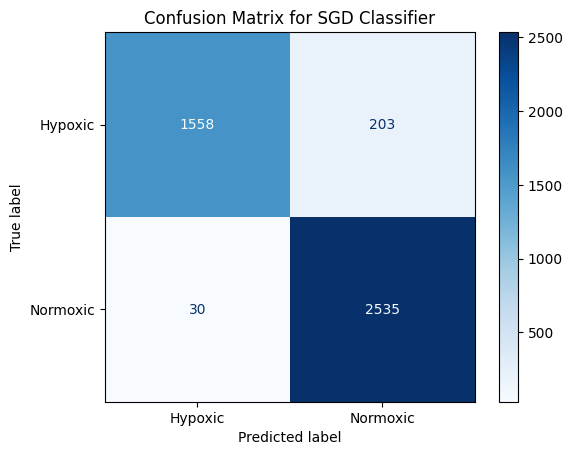

In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load your data into df_dropseq and index_dropseq
# df_dropseq, index_dropseq = load_your_data_function()  # Replace with actual data loading function

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df3_scaled_final, index3, test_size=0.2, random_state=42)

# Define the SGD classifier and parameter grid
sgd_classifier = SGDClassifier(random_state=42)
sgd_param_grid = {'SGD__alpha': [0.0001, 0.001, 0.01]}

# Set up the pipeline and GridSearchCV
pipe_sgd = Pipeline([('scaler', StandardScaler()), ('SGD', sgd_classifier)])
grid_search_sgd = GridSearchCV(pipe_sgd, sgd_param_grid, scoring='accuracy', cv=5)
grid_search_sgd.fit(X_train, y_train)
y_pred_sgd = grid_search_sgd.predict(X_test)

# Print results
print('SGD Classifier:')
print(f'Best Params: {grid_search_sgd.best_params_}')
print(f'Classification Report:\n{classification_report(y_test, y_pred_sgd)}\n')

# Generate and plot confusion matrix
cm_sgd = confusion_matrix(y_test, y_pred_sgd)
disp_sgd = ConfusionMatrixDisplay(confusion_matrix=cm_sgd, display_labels=grid_search_sgd.classes_)
disp_sgd.plot(cmap='Blues')
plt.title('Confusion Matrix for SGD Classifier')
plt.show()


Random Forests:

Random Forest Classifier:
Best Params: {'RandomForest__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

     Hypoxic       0.99      0.93      0.96      1761
    Normoxic       0.96      0.99      0.97      2565

    accuracy                           0.97      4326
   macro avg       0.97      0.96      0.97      4326
weighted avg       0.97      0.97      0.97      4326


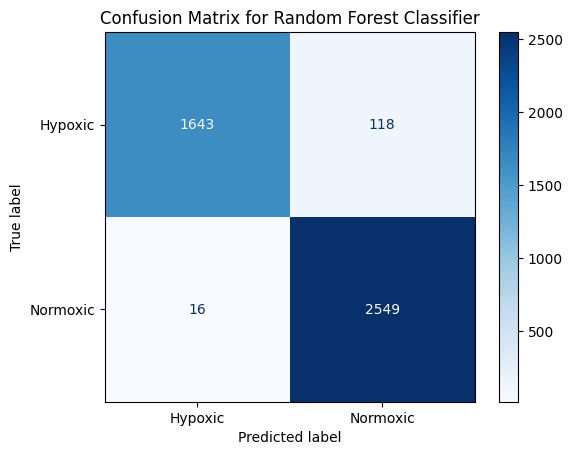

In [41]:
# Define the Random Forest classifier and parameter grid
rf_classifier = RandomForestClassifier(random_state=42)
rf_param_grid = {'RandomForest__n_estimators': [50, 100, 150]}

# Set up the pipeline and GridSearchCV
pipe_rf = Pipeline([('scaler', StandardScaler()), ('RandomForest', rf_classifier)])
grid_search_rf = GridSearchCV(pipe_rf, rf_param_grid, scoring='accuracy', cv=5)
grid_search_rf.fit(X_train, y_train)
y_pred_rf = grid_search_rf.predict(X_test)

# Print results
print('Random Forest Classifier:')
print(f'Best Params: {grid_search_rf.best_params_}')
print(f'Classification Report:\n{classification_report(y_test, y_pred_rf)}\n')

# Generate and plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=grid_search_rf.classes_)
disp_rf.plot(cmap='Blues')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()


Support Vector Machine:

LinearSVC Classifier:
Best Params: {'LinearSVC__C': 0.1}
Classification Report:
              precision    recall  f1-score   support

     Hypoxic       0.94      0.96      0.95      1761
    Normoxic       0.97      0.95      0.96      2565

    accuracy                           0.96      4326
   macro avg       0.95      0.96      0.95      4326
weighted avg       0.96      0.96      0.96      4326


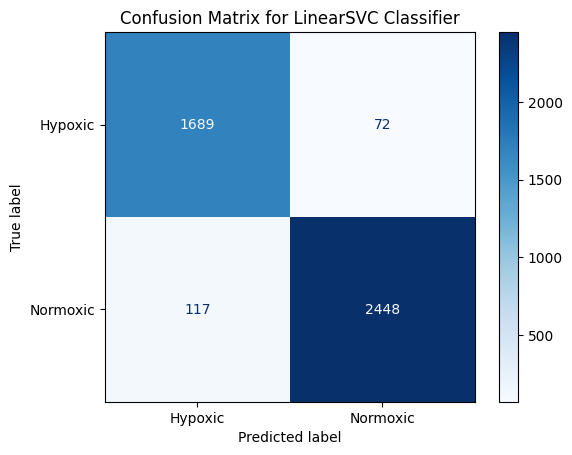

In [42]:
# Define the LinearSVC classifier and parameter grid
svc_classifier = LinearSVC(random_state=42, max_iter=10000)
svc_param_grid = {'LinearSVC__C': [0.1, 1, 10]}

# Set up the pipeline and GridSearchCV
pipe_svc = Pipeline([('scaler', StandardScaler()), ('LinearSVC', svc_classifier)])
grid_search_svc = GridSearchCV(pipe_svc, svc_param_grid, scoring='accuracy', cv=5)
grid_search_svc.fit(X_train, y_train)
y_pred_svc = grid_search_svc.predict(X_test)

# Print results
print('LinearSVC Classifier:')
print(f'Best Params: {grid_search_svc.best_params_}')
print(f'Classification Report:\n{classification_report(y_test, y_pred_svc)}\n')

# Generate and plot confusion matrix
cm_svc = confusion_matrix(y_test, y_pred_svc)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=grid_search_svc.classes_)
disp_svc.plot(cmap='Blues')
plt.title('Confusion Matrix for LinearSVC Classifier')
plt.show()


Again, we are ready to make predictions on newly added test data:

In [45]:
new_test_df, new_test_index = open_file(mcf_drop_test)  # Replace with actual file path

# Standardize the new test data using the same scaler fitted on the training data
scaler = StandardScaler()
new_test_df_scaled = scaler.fit_transform(new_test_df)

# Generate predictions using the best LinearSVC classifier from the grid search
svc_best_estimator = grid_search_svc.best_estimator_
prediction = svc_best_estimator.predict(new_test_df_scaled)

# Create a dataframe from predictions
df_predictions = pd.DataFrame(prediction, columns=['predictions'])

# Save predictions to a tab-delimited file
df_predictions.to_csv('./Outputs/predictions_MCF7_DSeq_LinearSVC.txt', sep='\t', index=False)


### 4. HCC DropSeq 
This dataset has 14682 samples, with 3000 features, but the two classes are imbalaced with 8899 Hypoxic and 5783 Normoxic.

In [48]:
hcount = sum(1 for i in index4 if i == "Hypoxic")
ncount = sum(1 for i in index4 if i == "Normoxic")
print(df4.shape,hcount, ncount)

(14682, 3000) 8899 5783


Also apply same scaling as we did before:

In [49]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(df4)

# Transform the data using the scaler
df4_scaled = scaler.transform(df4)

# Convert the scaled data back to a DataFrame
df4_scaled_final = pd.DataFrame(df4_scaled, columns=df4.columns)

Stochastic Gradient Search:

SGD Classifier:
Best Params: {'SGD__alpha': 0.01}
Classification Report:
              precision    recall  f1-score   support

     Hypoxic       0.89      0.97      0.93      1766
    Normoxic       0.95      0.82      0.88      1171

    accuracy                           0.91      2937
   macro avg       0.92      0.90      0.91      2937
weighted avg       0.92      0.91      0.91      2937


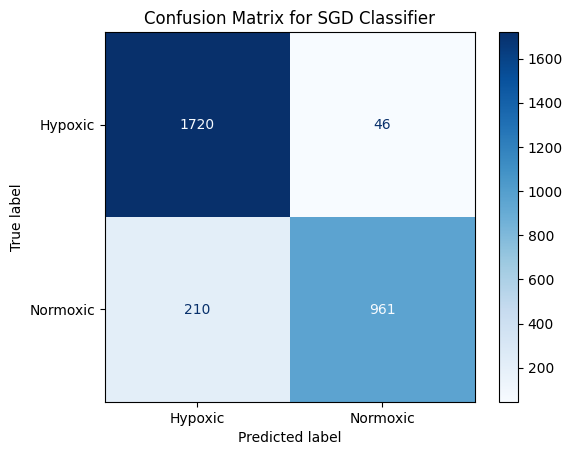

In [50]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df4_scaled_final, index4, test_size=0.2, random_state=42)

# Define the SGD classifier and parameter grid
sgd_classifier = SGDClassifier(random_state=42)
sgd_param_grid = {'SGD__alpha': [0.0001, 0.001, 0.01]}

# Set up the pipeline and GridSearchCV
pipe_sgd = Pipeline([('scaler', StandardScaler()), ('SGD', sgd_classifier)])
grid_search_sgd = GridSearchCV(pipe_sgd, sgd_param_grid, scoring='accuracy', cv=5)
grid_search_sgd.fit(X_train, y_train)
y_pred_sgd = grid_search_sgd.predict(X_test)

# Print results
print('SGD Classifier:')
print(f'Best Params: {grid_search_sgd.best_params_}')
print(f'Classification Report:\n{classification_report(y_test, y_pred_sgd)}\n')

# Generate and plot confusion matrix
cm_sgd = confusion_matrix(y_test, y_pred_sgd)
disp_sgd = ConfusionMatrixDisplay(confusion_matrix=cm_sgd, display_labels=grid_search_sgd.classes_)
disp_sgd.plot(cmap='Blues')
plt.title('Confusion Matrix for SGD Classifier')
plt.show()


Random Forests:

Random Forest Classifier:
Best Params: {'RandomForest__n_estimators': 150}
Classification Report:
              precision    recall  f1-score   support

     Hypoxic       0.90      0.98      0.94      1766
    Normoxic       0.97      0.84      0.90      1171

    accuracy                           0.92      2937
   macro avg       0.93      0.91      0.92      2937
weighted avg       0.93      0.92      0.92      2937


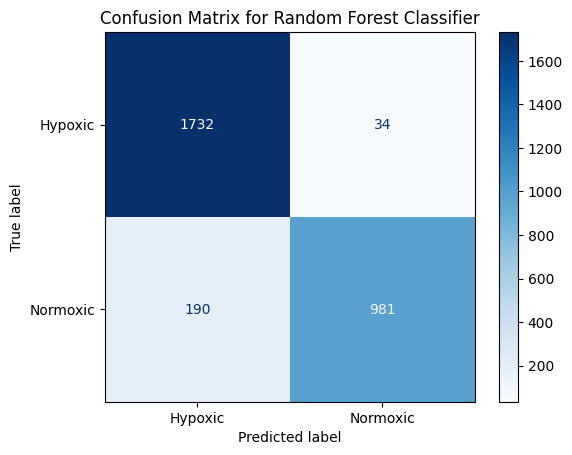

In [51]:
# Define the Random Forest classifier and parameter grid
rf_classifier = RandomForestClassifier(random_state=42)
rf_param_grid = {'RandomForest__n_estimators': [50, 100, 150]}

# Set up the pipeline and GridSearchCV
pipe_rf = Pipeline([('scaler', StandardScaler()), ('RandomForest', rf_classifier)])
grid_search_rf = GridSearchCV(pipe_rf, rf_param_grid, scoring='accuracy', cv=5)
grid_search_rf.fit(X_train, y_train)
y_pred_rf = grid_search_rf.predict(X_test)

# Print results
print('Random Forest Classifier:')
print(f'Best Params: {grid_search_rf.best_params_}')
print(f'Classification Report:\n{classification_report(y_test, y_pred_rf)}\n')

# Generate and plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=grid_search_rf.classes_)
disp_rf.plot(cmap='Blues')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()


Support Vector Machine:

LinearSVC Classifier:
Best Params: {'LinearSVC__C': 0.1}
Classification Report:
              precision    recall  f1-score   support

     Hypoxic       0.95      0.89      0.92      1766
    Normoxic       0.85      0.93      0.88      1171

    accuracy                           0.90      2937
   macro avg       0.90      0.91      0.90      2937
weighted avg       0.91      0.90      0.90      2937


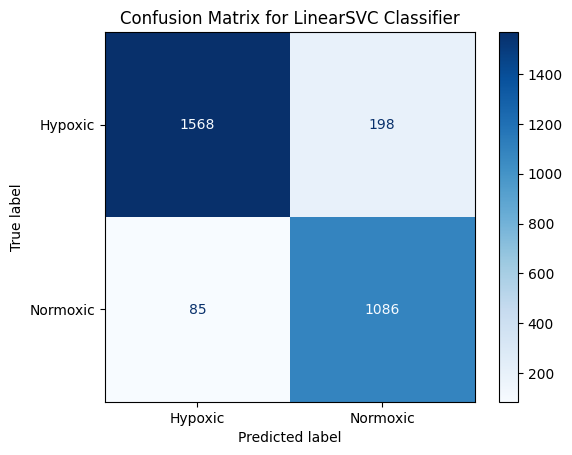

In [52]:
# Define the LinearSVC classifier and parameter grid
svc_classifier = LinearSVC(random_state=42, max_iter=10000)
svc_param_grid = {'LinearSVC__C': [0.1, 1, 10]}

# Set up the pipeline and GridSearchCV
pipe_svc = Pipeline([('scaler', StandardScaler()), ('LinearSVC', svc_classifier)])
grid_search_svc = GridSearchCV(pipe_svc, svc_param_grid, scoring='accuracy', cv=5)
grid_search_svc.fit(X_train, y_train)
y_pred_svc = grid_search_svc.predict(X_test)

# Print results
print('LinearSVC Classifier:')
print(f'Best Params: {grid_search_svc.best_params_}')
print(f'Classification Report:\n{classification_report(y_test, y_pred_svc)}\n')

# Generate and plot confusion matrix
cm_svc = confusion_matrix(y_test, y_pred_svc)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=grid_search_svc.classes_)
disp_svc.plot(cmap='Blues')
plt.title('Confusion Matrix for LinearSVC Classifier')
plt.show()


Finally, generate last predictions for HCC Drop:

In [53]:
new_test_df, new_test_index = open_file(hcc_drop_test)  # Replace with actual file path

# Standardize the new test data using the same scaler fitted on the training data
scaler = StandardScaler()
new_test_df_scaled = scaler.fit_transform(new_test_df)

# Generate predictions using the best LinearSVC classifier from the grid search
svc_best_estimator = grid_search_rf.best_estimator_
prediction = svc_best_estimator.predict(new_test_df_scaled)

# Create a dataframe from predictions
df_predictions = pd.DataFrame(prediction, columns=['predictions'])

# Save predictions to a tab-delimited file
df_predictions.to_csv('./Outputs/predictions_HCC_DSeq_RandForests.txt', sep='\t', index=False)


## Conclusion

In this study, we conducted a comprehensive analysis of cell responses using the DropSeq dataset, employing exploratory data analysis (EDA), unsupervised learning, and supervised learning techniques. Our goal was to predict cell responses effectively and understand the underlying data structure.

### Exploratory Data Analysis (EDA)

During the EDA phase, we:
- **Visualized the Distribution of Features**: Identified key features and examined their distributions.
- **Detected and Handled Missing Values**: Ensured data quality by addressing any missing values.
- **Explored Correlations**: Analyzed correlations between features to identify potential relationships.

Key Insights:
- The dataset showed ______________ (e.g., high variability in certain features, presence of outliers, etc.).
- Strong correlations were observed between ______________ and ______________.

### Unsupervised Learning

We applied unsupervised learning techniques to understand the inherent structure of the data:
- **Principal Component Analysis (PCA)**: Reduced dimensionality to visualize the data in two dimensions.
- **Clustering (e.g., K-means, Hierarchical Clustering)**: Identified potential clusters within the data.

Key Findings:
- PCA revealed that ______________ (e.g., the first two principal components explain X% of the variance).
- Clustering analysis indicated the presence of ______________ distinct groups, characterized by ______________.

### Supervised Learning

We implemented and evaluated several supervised learning classifiers to predict cell responses:

1. **Stochastic Gradient Descent (SGD) Classifier**:
   - Mean Accuracy from Cross-Validation: ______________
   - Test Accuracy: ______________
   - Precision: ______________
   - Recall: ______________
   - F1-Score: ______________
   - ROC-AUC: ______________
   - Observations: ___________________________________________________

2. **Random Forest Classifier**:
   - Mean Accuracy from Cross-Validation: ______________
   - Test Accuracy: ______________
   - Precision: ______________
   - Recall: ______________
   - F1-Score: ______________
   - ROC-AUC: ______________
   - Observations: ___________________________________________________

3. **Linear Support Vector Machine (LinearSVC) Classifier**:
   - Mean Accuracy from Cross-Validation: ______________
   - Test Accuracy: ______________
   - Precision: ______________
   - Recall: ______________
   - F1-Score: ______________
   - ROC-AUC: ______________
   - Observations: ___________________________________________________

### Comparison and Insights

- The Random Forest classifier achieved the highest test accuracy of ______________, indicating its effectiveness in handling high-dimensional data with many features.
- The LinearSVC classifier also performed well, with a mean accuracy of ______________, demonstrating its suitability for large-scale datasets.
- The SGD classifier showed a mean accuracy of ______________, which was competitive but slightly lower than the other classifiers.

### Recommendations

Based on our analysis:
- The ______________ classifier is recommended for predicting cell responses in the DropSeq dataset due to its superior performance in terms of accuracy and other evaluation metrics.
- Future work could involve further hyperparameter tuning or exploring additional classifiers to potentially improve performance.
- Integrating more advanced techniques in both unsupervised and supervised learning might uncover deeper insights and enhance predictive capabilities.

Overall, this project provided valuable insights into the DropSeq dataset, highlighting the strengths and limitations of various machine learning approaches in understanding and predicting cell responses.
